In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from operators import dL, dR, dL_dag, dR_dag


### Symbolic representation

In [2]:
epsL, epsR = sp.symbols('ϵ_L,ϵ_R') #Onsite energies
t, Delta = sp.symbols('t,Δ') #tunneling and pairing amplit
U = sp.symbols('U') #Coulomb interaction


def create_Hamiltonian():
    """Create the Hamiltonian for the system.
    H = H_onsite + H_tunnel + H_pairing + H_coulomb

    """
    H_onsite = epsL * dL_dag * dL + epsR * dR_dag * dR
    H_tunnel = t * (dL_dag * dR + dR_dag * dL)
    H_pairing = Delta * (dR * dL + dL_dag * dR_dag)
    H_coulomb = U * (dL_dag * dL) * (dR_dag * dR)

    H = H_onsite + H_tunnel + H_pairing + H_coulomb
    return H

# def block_diagonal_Hamiltonian():
#     """Create the block diagonal Hamiltonian for the system."""
#     S = epsL + epsR + U
#     H_even = sp.Matrix([
#         [0, Delta],
#         [Delta, S]
#     ])
#     H_odd = sp.Matrix([
#         [epsR, t],
#         [t, epsL]
#     ])
#     return H_even, H_odd

H = create_Hamiltonian()
H_matrix = sp.Matrix(H)
eigenvals = H_matrix.eigenvals()
eigenvects = H_matrix.eigenvects()
print("Hamiltonian Matrix:")
sp.pprint(H_matrix)
print("\nEigenvalues:")
for val, mult in eigenvals.items():
    sp.pprint(val)
    print("Multiplicity:", mult)
print("\nEigenvectors:")
for val, mult, vects in eigenvects:
    print("Eigenvalue:")
    sp.pprint(val)
    print("Multiplicity:", mult)
    print("Eigenvectors:")
    for vect in vects:
        sp.pprint(vect)
    print()
    

Hamiltonian Matrix:
⎡0   0    0         Δ      ⎤
⎢                          ⎥
⎢0  ϵ_R   t         0      ⎥
⎢                          ⎥
⎢0   t   ϵ_L        0      ⎥
⎢                          ⎥
⎣Δ   0    0   U + ϵ_L + ϵ_R⎦

Eigenvalues:
                   _________________________________________________________
                  ╱  2                          2      2                  2 
U   ϵ_L   ϵ_R   ╲╱  U  + 2⋅U⋅ϵ_L + 2⋅U⋅ϵ_R + 4⋅Δ  + ϵ_L  + 2⋅ϵ_L⋅ϵ_R + ϵ_R  
─ + ─── + ─── - ────────────────────────────────────────────────────────────
2    2     2                                 2                              
Multiplicity: 1
                   _________________________________________________________
                  ╱  2                          2      2                  2 
U   ϵ_L   ϵ_R   ╲╱  U  + 2⋅U⋅ϵ_L + 2⋅U⋅ϵ_R + 4⋅Δ  + ϵ_L  + 2⋅ϵ_L⋅ϵ_R + ϵ_R  
─ + ─── + ─── + ────────────────────────────────────────────────────────────
2    2     2                                 2        

### Functions for numerical conversion

In [65]:
def d_operators():
    """ Numpy version of the d operators."""
    dL = np.array([[0,0,1,0],[0,0,0,1],[0,0,0,0],[0,0,0,0]])
    dL_dag =  dL.T
    dR = np.array([[0,1,0,0],[0,0,0,0],[0,0,0,-1],[0,0,0,0]])
    dR_dag = dR.T
    return dL, dR, dL_dag, dR_dag

def symbolic_to_numeric(input_expr, epsL_val, epsR_val, t_val, Delta_val, U_val):
    """Takes either a symbolic scipy matrix or vector and substitutes the symbolic parameters with numerical values.
    """
    subs_dict = {epsL: epsL_val, epsR: epsR_val, t: t_val, Delta: Delta_val, U: U_val}
    if isinstance(input_expr, sp.Matrix):
        numeric_expr = input_expr.subs(subs_dict).evalf()
        return np.array(numeric_expr).astype(np.complex128)
    elif isinstance(input_expr, list):
        numeric_list = []
        for item in input_expr:
            if isinstance(item, tuple) and len(item) == 3:
                val, mult, vects = item
                numeric_val = val.subs(subs_dict).evalf()
                numeric_vects = [sp.Matrix(vect).subs(subs_dict).evalf() for vect in vects]
                numeric_list.append((numeric_val, mult, numeric_vects))
            else:
                raise ValueError("List items must be tuples of (eigenvalue, multiplicity, eigenvectors).")
        return numeric_list
    else:
        raise TypeError("Input must be a sympy Matrix.")

def find_groundstate_energystates(eigvects):
    """ 
    Transforming symbolic matrix to numeric, gives us three parameters for each vector: value, multiplicity, and the vector itself.
    Use this function to separate the ground state from the excited states.

    Returns:
        ground_state: tuple (eigenvalue, eigenvector)
        excited_states: list of tuples [(eigenvalue, eigenvector), ...] 
    """
    numer_of_states = len(eigvects)
    if numer_of_states == 0:
        raise ValueError("No eigenvectors provided.")
    
    # Can i use np.sort to sort the eigenvalues? and still keep track of the eigenvectors?
    # Or should I just loop through and find the minimum?
    sorted_states = sorted(eigvects, key=lambda x: x[0])
    ground_state = sorted_states[0]
    excited_states = sorted_states[1:]
    return ground_state, excited_states[0]



# Example usage:
H_numeric = symbolic_to_numeric(H_matrix, epsL_val=1.0, epsR_val=1.0, t_val=0.5, Delta_val=0.5, U_val=1.5)
print("Numeric Hamiltonian Matrix:")
print(H_numeric)

H_symbolic = sp.Matrix(H)
eigvals, eigvects = H_symbolic.eigenvals(), H_symbolic.eigenvects()

eigvects_numeric = symbolic_to_numeric(eigvects, epsL_val=1.0, epsR_val=1.0, t_val=0.5, Delta_val=0.5, U_val=1.5)

print("Numeric Eigenvectors:")
for val, mult, vects in eigvects_numeric:
    print(f"Eigenvalue: {val}, Multiplicity: {mult}")
    for vect in vects:
        numeric_vect = symbolic_to_numeric(sp.Matrix(vect), epsL_val=1.0, epsR_val=1.0, t_val=0.5, Delta_val=0.5, U_val=1.5)
        print("Eigenvector:", numeric_vect)


sorted_states = find_groundstate_energystates(eigvects_numeric)
ground_state, excited_states = sorted_states


Numeric Hamiltonian Matrix:
[[0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 1. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 1. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 3.5+0.j]]
Numeric Eigenvectors:
Eigenvalue: 0.500000000000000, Multiplicity: 1
Eigenvector: [[ 0.+0.j]
 [-1.+0.j]
 [ 1.+0.j]
 [ 0.+0.j]]
Eigenvalue: 1.50000000000000, Multiplicity: 1
Eigenvector: [[0.+0.j]
 [1.+0.j]
 [1.+0.j]
 [0.+0.j]]
Eigenvalue: -0.0700274723201295, Multiplicity: 1
Eigenvector: [[-7.14005494+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 1.        +0.j]]
Eigenvalue: 3.57002747232013, Multiplicity: 1
Eigenvector: [[0.14005494+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [1.        +0.j]]


### Majorana Properties

In [ ]:

def Energy_degeneracy(even_eigvals, odd_eigvals):
    """Calculate the energy degeneracy δE.

    Args:
        Even eigenvalues (list): List of even eigenvalues.
        Odd eigenvalues (list): List of odd eigenvalues.
    """
    even_sorted = np.sort(even_eigvals)
    odd_sorted = np.sort(odd_eigvals)

    gs_even = even_sorted[0]
    gs_odd = odd_sorted[0]
    excited_even = even_sorted[1]
    excited_odd = odd_sorted[1]

    deltaE_gs = abs(gs_even - gs_odd)
    deltaE_es = abs(min(excited_even, excited_odd) - max(gs_even, gs_odd))
    if deltaE_es == 0:
        return 1
    return deltaE_gs / deltaE_es


def even_odd_density_matrices(gs_even, gs_odd):
    
    rho_even = np.outer(gs_even, np.conj(gs_even))
    rho_odd = np.outer(gs_odd, np.conj(gs_odd))

    return rho_even, rho_odd

def partial_trace(rho, keep):
    """
    Compute partial trace over one subsystem in a 2-site (4x4) density matrix.
    keep = 'L' or 'R'
    """
    rho = rho.reshape(2, 2, 2, 2)  # indices: (L, R, L', R')

    if keep == 'L':
        # trace over R (sum over R and R')
        rho_reduced = np.einsum('ijkl->jl', rho)
    elif keep == 'R':
        # trace over L (sum over L and L')
        rho_reduced = np.einsum('ijkl->ik', rho)
    else:
        raise ValueError("keep must be 'L' or 'R'")

    return rho_reduced


def Local_distinguishability(rho_even, rho_odd):
    """Calculateth e local distinguishability LD
    
    Using the even and odd density matrices rho_even and rho_odd,
    we can calculate
    LD = 1/N ∑_j^N || ρ_j^o - ρ_j^e || = 1/N ∑_j^N ||δρ_j||

    Args:
        rho_even (np.array): Even density matrix.
        rho_odd (np.array): Odd density matrix.
    
    """
    rhoL_even = partial_trace(rho_even, 'L')
    rhoR_even = partial_trace(rho_even, 'R')
    rhoL_odd  = partial_trace(rho_odd, 'L')
    rhoR_odd  = partial_trace(rho_odd, 'R')

    # Differences
    delta_rhoL = rhoL_odd - rhoL_even
    delta_rhoR = rhoR_odd - rhoR_even

    # Frobenius norms
    normL = np.linalg.norm(delta_rhoL, ord='fro')
    normR = np.linalg.norm(delta_rhoR, ord='fro')

    LD = 0.5 * (normL + normR) / np.sqrt(2)
    return LD

def W_alpha(Odd_gs, Even_gs):
    """Calculate the Majorana wavefunction amplitudes W_alpha.

    Args:
        Odd_gs (np.array): Odd ground state.
        Even_gs (np.array): Even ground state.
    """

    dL, dR, dL_dag, dR_dag = d_operators()


    # print(Odd_gs.shape, Even_gs.shape, dL.shape, dR.shape)
    WL = np.vdot(Odd_gs, (dL + dL_dag) @ Even_gs)
    WR = np.vdot(Odd_gs, (dR + dR_dag) @ Even_gs)
    # print(WL, WR)
    return WL, WR

def Z_alpha(Odd_gs, Even_gs):
    """Calculate the Majorana wavefunction amplitudes Z_alpha.

    Args:
        Odd_gs (np.array): Odd ground state.
        Even_gs (np.array): Even ground state.
    """
    dL, dR, dL_dag, dR_dag = d_operators()

    ZL = np.vdot(Odd_gs, (dL - dL_dag) @ Even_gs)
    ZR = np.vdot(Odd_gs, (dR - dR_dag) @ Even_gs)
    return ZL, ZR


def Majorana_Polarization(Odd_gs, Even_gs):
    """Calculate the Majorana polarization.

    Args:
        Odd_gs (np.array): Odd ground state.
        Even_gs (np.array): Even ground state.
    """
    # print(Odd_gs.shape, Even_gs.shape)
    WL, WR = W_alpha(Odd_gs, Even_gs)
    ZL, ZR = Z_alpha(Odd_gs, Even_gs)

    WL2 = np.abs(WL)**2
    WR2 = np.abs(WR)**2
    ZL2 = np.abs(ZL)**2
    ZR2 = np.abs(ZR)**2

    ML = (WL2 - ZL2) / (WL2 + ZL2) if (WL2 + ZL2) != 0 else 0
    MR = (WR2 - ZR2) / (WR2 + ZR2) if (WR2 + ZR2) != 0 else 0

    return ML, MR



In [ ]:
def interstate_params(U_inter, t):
    """Calculate the interstate parameters for the system.""" 
    U_inter = float(U_inter)
    t = float(t)
    epsL = -U_inter / 2
    epsR = -U_inter / 2
    Delta = t + U_inter / 2
    return epsL, epsR, Delta

def sep_even_odd(eigenvectors):
    """ 
    Input eigenvectors 4D are three parameter lists (val, mult, vect)
    
    Return:
    Even List ∝ (1,0,0,1) (val, mult, vect)
    Odd list ∝ (0,1,1,0)  (val, mult, vect)
    """

    even_vec = np.array([1,0,0,1])
    odd_vec = np.array([0,1,1,0])

    Even = []
    Odd = []
    
    for i, vector in enumerate(eigenvectors):
        val, mul, vec = vector
        vec_arr = convert_vec_to_numpy(vec)#np.array(vec,dtype=np.complex128)[0]
        # print("vec_arr: ", vec_arr)

        if np.allclose(vec_arr.T.conj() * even_vec, vec_arr.T):
            Even.append(vector)
        elif np.allclose(vec_arr.T.conj() * odd_vec, vec_arr.T):
            Odd.append(vector)
        else:
            print("Look here: vec array: ",vec_arr)
            raise ValueError("Something aint right")
    
    return Even, Odd


def convert_vec_to_numpy(vec):
    """
    Convert a sympy eigenvector (Matrix or nested structure) to a normalized numpy vector.
    Handles infinities and nans safely.
    """
    # Flatten any Sympy Matrix or nested list structure
    if isinstance(vec, sp.Matrix):
        elements = vec
    elif isinstance(vec, (list, tuple)):
        # Sympy eigenvects often wrap vectors in extra lists
        elements = vec[0] if isinstance(vec[0], sp.Matrix) else vec
    else:
        raise TypeError(f"Unexpected vector type: {type(vec)}")

    # Convert each symbolic entry to a complex number
    vals = []
    for entry in elements:
        try:
            vals.append(complex(entry.evalf()))
            # print("A")
        except Exception:
            # Handle nested matrices or unevaluated symbolic stuff
            if isinstance(entry, sp.Matrix):
                vals.append(complex(entry[0].evalf()))
            else:
                raise ValueError(f"Failed to convert entry {entry} to complex number.")
               
    vec_eval = np.array(vals, dtype=np.complex128).flatten()

    # Replace NaN/inf with zero, then normalize
    vec_eval = np.nan_to_num(vec_eval, nan=0.0, posinf=0.0, neginf=0.0)

    norm = np.linalg.norm(vec_eval)
    if norm == 0:
        raise ValueError("Zero-norm eigenvector encountered (likely degenerate).")
    return vec_eval / norm




# H_even, H_odd = block_diagonal_Hamiltonian() 
# even_eigenvecs = H_even.eigenvects()
# odd_eigenvecs = H_odd.eigenvects()

H_symbolic = create_Hamiltonian()
eigvecs = H_symbolic.eigenvects()
 


U_inter = np.linspace(-5, 5, 50)
t_vals = np.linspace(0.1, 3, 10)
degeneracies = np.zeros((len(t_vals), len(U_inter)))
LDs = np.zeros((len(t_vals), len(U_inter)))
MLs = np.zeros((len(t_vals), len(U_inter)))
MRs = np.zeros((len(t_vals), len(U_inter)))


for i, t_val in enumerate(t_vals):
    for j, U_val in enumerate(U_inter):
        epsL_val, epsR_val, Delta_val = interstate_params(U_val, t_val)

        eigvects_numeric = symbolic_to_numeric(eigvecs, epsL_val=epsL_val, epsR_val=epsR_val, t_val=t_val, Delta_val=Delta_val, U_val=U_val)

        Even, Odd = sep_even_odd(eigvects_numeric)

        GS_even, EX_even = find_groundstate_energystates(Even)
        GS_odd, EX_odd = find_groundstate_energystates(Odd)

        gs_even_eigval, _, gs_even_eigvec = GS_even
        ex_even_eigval, _, ex_even_eigvec = EX_even
        gs_odd_eigval, _, gs_odd_eigvec = GS_odd
        ex_odd_eigval, _, ex_odd_eigvec = EX_odd

        

        #Convert vectors to numpy arrays
        gs_even_eigvec = convert_vec_to_numpy(gs_even_eigvec)
        
        ex_even_eigvec = convert_vec_to_numpy(ex_even_eigvec)
        gs_odd_eigvec = convert_vec_to_numpy(gs_odd_eigvec)
        ex_odd_eigvec = convert_vec_to_numpy(ex_odd_eigvec)


        deltaE = Energy_degeneracy([gs_even_eigval, ex_even_eigval], [gs_odd_eigval, ex_odd_eigval])
        degeneracies[i, j] = deltaE



        rho_even, rho_odd = even_odd_density_matrices(gs_even_eigvec, gs_odd_eigvec)
        # print(rho_even, rho_odd)
        LD = Local_distinguishability(rho_even, rho_odd)
        LDs[i, j] = LD

        ML, MR = Majorana_Polarization(gs_odd_eigvec, gs_even_eigvec)
        MLs[i, j] = ML
        MRs[i, j] = MR



0.0 1.0


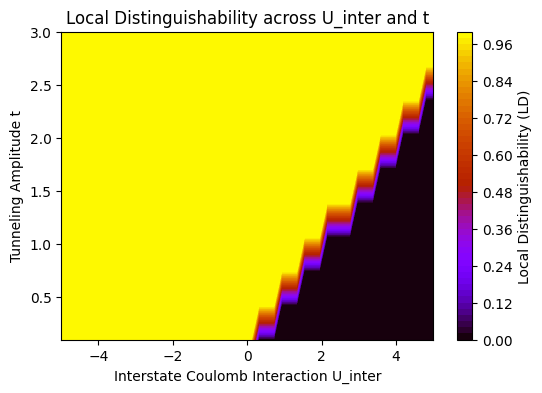

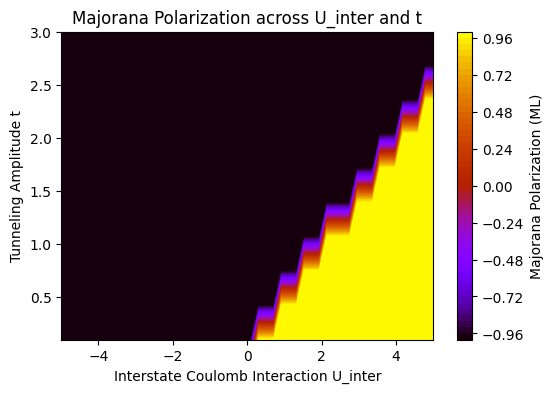

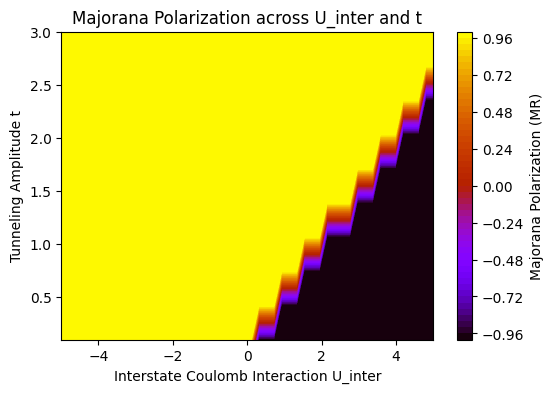

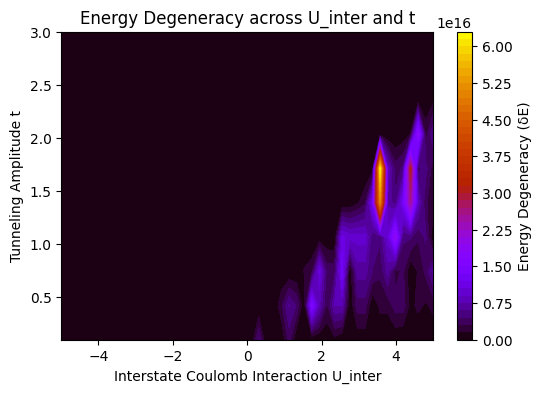

In [70]:
print(min(LDs.flatten()), max(LDs.flatten()))
plt.figure(figsize=(6, 4))
plt.contourf(U_inter, t_vals, LDs, levels=50, cmap='gnuplot', vmin=0, vmax=1)
plt.colorbar(label='Local Distinguishability (LD)')
# cf.set_clim(0, 1)
plt.xlabel('Interstate Coulomb Interaction U_inter')
plt.ylabel('Tunneling Amplitude t')
plt.title('Local Distinguishability across U_inter and t')
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(U_inter, t_vals, MLs, levels=50, cmap='gnuplot')
plt.colorbar(label='Majorana Polarization (ML)')
plt.xlabel('Interstate Coulomb Interaction U_inter')
plt.ylabel('Tunneling Amplitude t')
plt.title('Majorana Polarization across U_inter and t')
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(U_inter, t_vals, MRs, levels=50, cmap='gnuplot')
plt.colorbar(label='Majorana Polarization (MR)')
plt.xlabel('Interstate Coulomb Interaction U_inter')
plt.ylabel('Tunneling Amplitude t')
plt.title('Majorana Polarization across U_inter and t')
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(U_inter, t_vals, degeneracies, levels=50, cmap='gnuplot')
plt.colorbar(label='Energy Degeneracy (δE)')
plt.xlabel('Interstate Coulomb Interaction U_inter')
plt.ylabel('Tunneling Amplitude t')
plt.title('Energy Degeneracy across U_inter and t')
plt.show()  

In [72]:




H_symbolic = create_Hamiltonian()
eigvecs = H_symbolic.eigenvects()

U = 1.0
t_val = 1.0


eps_vals = np.linspace(-5, 5, 50)
Delta_vals = np.linspace(0.1, 3, 10)
degeneracies = np.zeros((len(Delta_vals), len(eps_vals)))
LDs = np.zeros((len(Delta_vals), len(eps_vals)))
MLs = np.zeros((len(Delta_vals), len(eps_vals)))
MRs = np.zeros((len(Delta_vals), len(eps_vals)))


for i, Delta_val in enumerate(Delta_vals):
    for j, eps_val in enumerate(eps_vals):
        # epsL_val, epsR_val, Delta_val = interstate_params(U_val, t_val)

        eigvects_numeric = symbolic_to_numeric(eigvecs, epsL_val=eps_val, epsR_val=eps_val, t_val=t_val, Delta_val=Delta_val, U_val=U)

        Even, Odd = sep_even_odd(eigvects_numeric)

        GS_even, EX_even = find_groundstate_energystates(Even)
        GS_odd, EX_odd = find_groundstate_energystates(Odd)

        gs_even_eigval, _, gs_even_eigvec = GS_even
        ex_even_eigval, _, ex_even_eigvec = EX_even
        gs_odd_eigval, _, gs_odd_eigvec = GS_odd
        ex_odd_eigval, _, ex_odd_eigvec = EX_odd

        

        #Convert vectors to numpy arrays
        gs_even_eigvec = convert_vec_to_numpy(gs_even_eigvec)
        
        ex_even_eigvec = convert_vec_to_numpy(ex_even_eigvec)
        gs_odd_eigvec = convert_vec_to_numpy(gs_odd_eigvec)
        ex_odd_eigvec = convert_vec_to_numpy(ex_odd_eigvec)


        deltaE = Energy_degeneracy([gs_even_eigval, ex_even_eigval], [gs_odd_eigval, ex_odd_eigval])
        degeneracies[i, j] = deltaE



        rho_even, rho_odd = even_odd_density_matrices(gs_even_eigvec, gs_odd_eigvec)
        # print(rho_even, rho_odd)
        LD = Local_distinguishability(rho_even, rho_odd)
        LDs[i, j] = LD

        ML, MR = Majorana_Polarization(gs_odd_eigvec, gs_even_eigvec)
        MLs[i, j] = ML
        MRs[i, j] = MR



0.0017006728938134081 0.7006501217913564


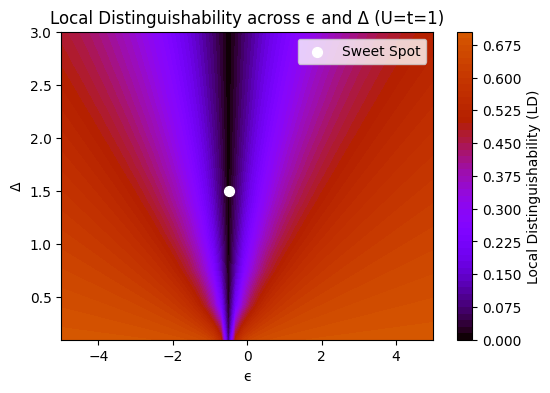

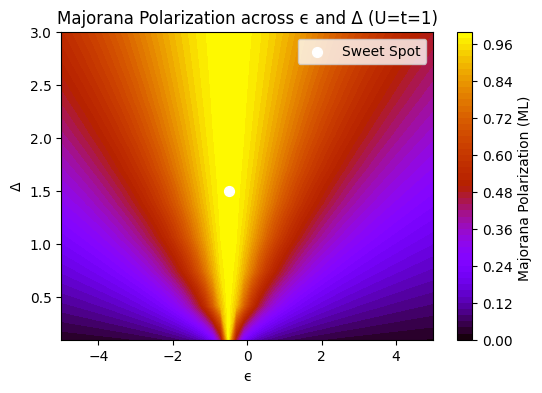

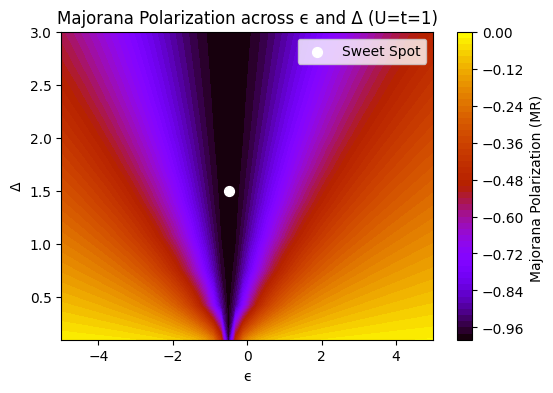

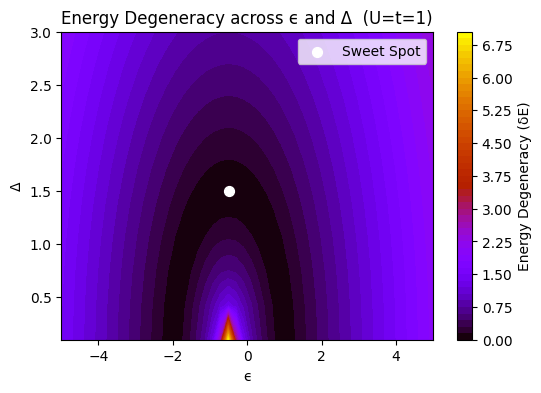

In [76]:
print(min(LDs.flatten()), max(LDs.flatten()))

epsilon_sweetspot = -U/2
delta_sweetspot = t_val + U/2
# Scatter the sweet spot


plt.figure(figsize=(6, 4))
plt.contourf(eps_vals, Delta_vals, LDs, levels=50, cmap='gnuplot', vmin=0, vmax=1)
plt.colorbar(label='Local Distinguishability (LD)')
plt.xlabel('ϵ')
plt.ylabel('Δ')
plt.title('Local Distinguishability across ϵ and Δ (U=t=1)')
plt.scatter(epsilon_sweetspot, delta_sweetspot, color='white', s=50, label='Sweet Spot')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(eps_vals, Delta_vals, MLs, levels=50, cmap='gnuplot')
plt.colorbar(label='Majorana Polarization (ML) ')
plt.xlabel('ϵ')
plt.ylabel('Δ')
plt.title('Majorana Polarization across ϵ and Δ (U=t=1)')
plt.scatter(epsilon_sweetspot, delta_sweetspot, color='white', s=50, label='Sweet Spot')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(eps_vals, Delta_vals, MRs, levels=50, cmap='gnuplot')
plt.colorbar(label='Majorana Polarization (MR) ')
plt.xlabel('ϵ')
plt.ylabel('Δ')
plt.title('Majorana Polarization across ϵ and Δ (U=t=1)')
plt.scatter(epsilon_sweetspot, delta_sweetspot, color='white', s=50, label='Sweet Spot')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.contourf(eps_vals, Delta_vals, degeneracies, levels=50, cmap='gnuplot')
plt.colorbar(label='Energy Degeneracy (δE)')
plt.xlabel('ϵ')
plt.ylabel('Δ')
plt.title('Energy Degeneracy across ϵ and Δ  (U=t=1)')
plt.scatter(epsilon_sweetspot, delta_sweetspot, color='white', s=50, label='Sweet Spot')
plt.legend()
plt.show()